In [48]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pmlb as dsets
import numpy as np
import pickle as pkl
from os.path import join as oj
from copy import deepcopy
import pandas as pd
from numpy import array as arr

# sklearn models
sys.path.append('../scores')
import scores
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import interactions
from scipy import interpolate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
data_dir = '/scratch/users/vision/data/pmlb'
out_dir = '/scratch/users/vision/chandan/pmlb'
dset_names = deepcopy(dsets.classification_dataset_names)
dset_names.remove('kddcup') # # remove biggest dset
dset_names.remove('mnist') # # remove biggest dset
dset_names.remove('poker') # # remove biggest dset

dset_names = np.array(dset_names)
random_state = 42 # for each train_test_split

# train models
this code will save all the **classification** dsets and fit very quick models to each of them

In [5]:
# from train import fit_logit_and_rfs()
# fit_logit_and_rfs()

# analyze results

In [50]:
results = pd.DataFrame(pkl.load(open(oj(out_dir, 'classification_results.pkl'), 'rb')))

# plot
# sns.boxplot(data=[results['logit_test_score'], results['rf_test_score']])
# plt.xticks([0, 1], ['Logistic Regression', 'Random Forest'])
# plt.ylabel('Test Accuracy')
# plt.show()

# singlevar logistic vs logistic of curve

In [ ]:
from single_var_funcs import *
calc_single_var_scores(results, data_dir, out_dir, random_state, add_feature=True, all_features=False)

# load scores results

In [17]:
# full_results_162
full_results = pd.DataFrame(pkl.load(open(oj(out_dir, 'full_results_50.pkl'), 'rb')))

In [18]:
mean_scores = []
orig_mean = []
alt_mean = []
orig_top = []
alt_top = []
orig_top_mda = []
alt_top_mda = []
for i in range(full_results.shape[0]):
    row = full_results.iloc[i]
    
    
    orig = arr(row.logit_score_orig_onevar_list)
    alt = arr(row.logit_score_altered_onevar_list)
    feat_ranks = np.argsort(row.feature_scores_mdi)
    max_feat = feat_ranks[-1]
    orig_top.append(row.logit_score_orig_onevar_list[max_feat])
    alt_top.append(row.logit_score_altered_onevar_list[max_feat])

    feat_ranks = np.argsort(row.feature_scores_mda)
    max_feat = feat_ranks[-1]
    orig_top_mda.append(row.logit_score_orig_onevar_list[max_feat])
    alt_top_mda.append(row.logit_score_altered_onevar_list[max_feat])    
    
#     plt.hist(alt - orig)
    mean_scores.append(np.mean(alt - orig))
    orig_mean.append(np.mean(orig))
    alt_mean.append(np.mean(alt))
orig_top_mda = arr(orig_top_mda)
alt_top_mda = arr(alt_top_mda)
orig_top = arr(orig_top)
alt_top = arr(alt_top)

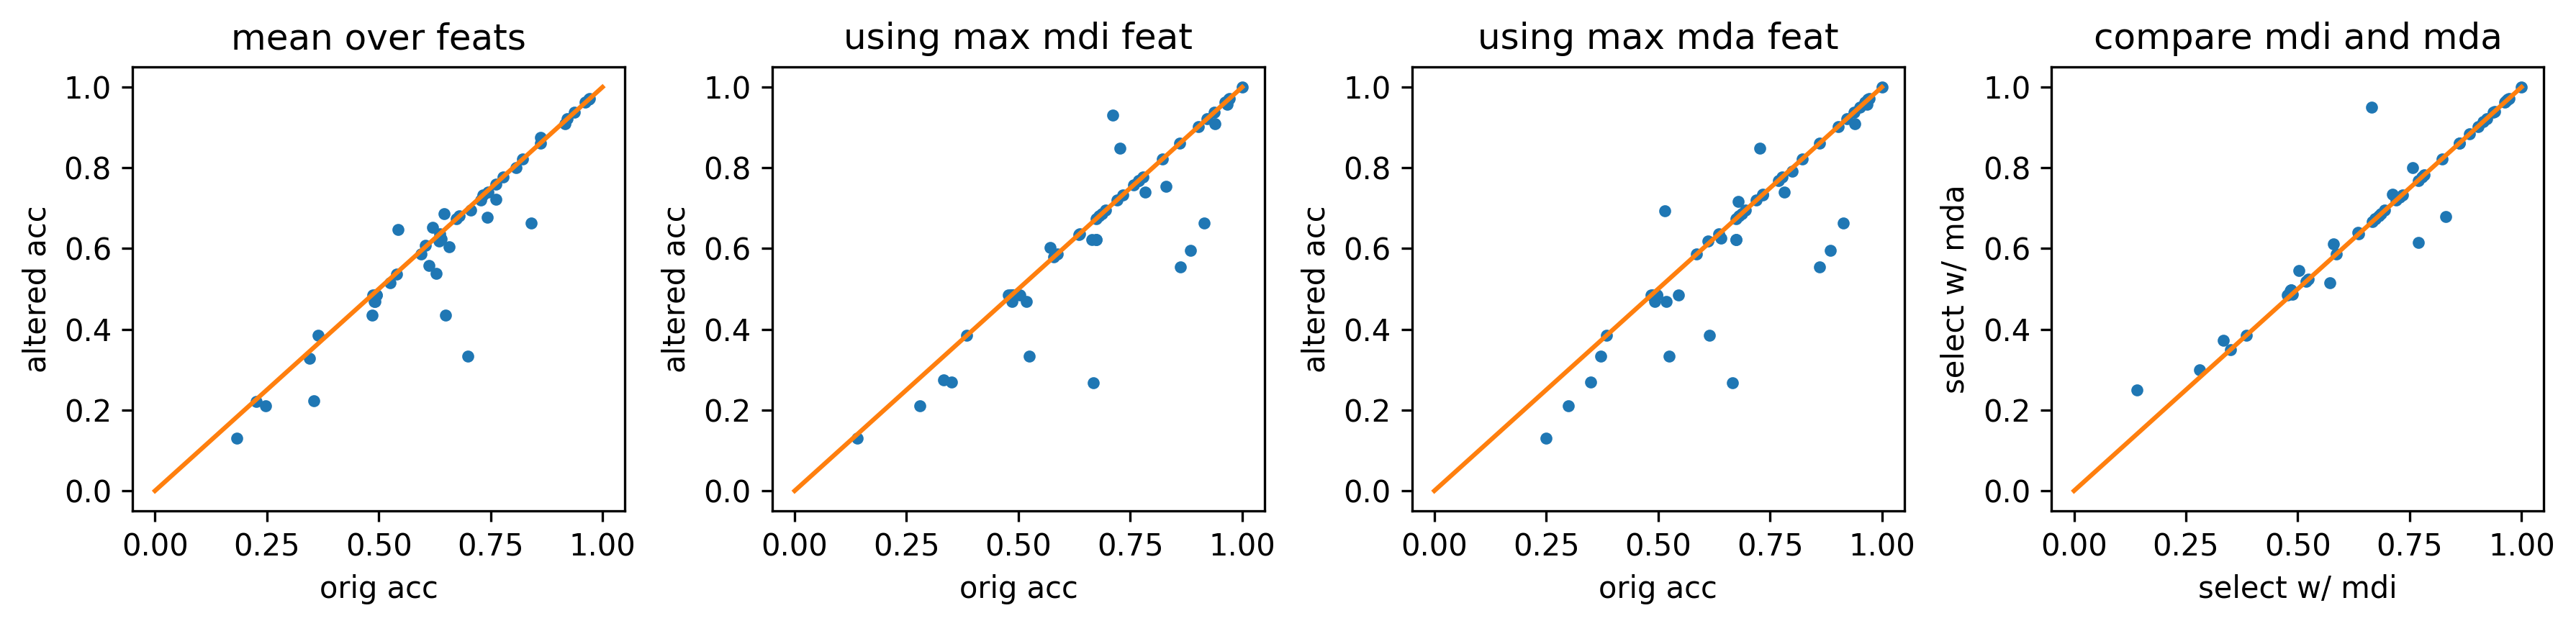

In [19]:
# note - these are, all, in fact binary classification

R, C, = 1, 4

plt.figure(figsize=(C * 3, R * 3), dpi=300) #, dpi=300)

plt.subplot(R, C, 1)
plt.title('mean over feats')
plt.plot(orig_mean, alt_mean, '.')
plt.plot([0, 1], [0, 1])
plt.xlabel('orig acc')
plt.ylabel('altered acc')

plt.subplot(R, C, 2)
plt.title('using max mdi feat')
plt.plot(orig_top, alt_top, '.')
plt.plot([0, 1], [0, 1])
plt.xlabel('orig acc')
plt.ylabel('altered acc')

plt.subplot(R, C, 3)
plt.title('using max mda feat')
plt.plot(orig_top_mda, alt_top_mda, '.')
plt.plot([0, 1], [0, 1])
plt.xlabel('orig acc')
plt.ylabel('altered acc')

plt.subplot(R, C, 4)
plt.title('compare mdi and mda')
plt.plot(orig_top, orig_top_mda, '.')
plt.plot([0, 1], [0, 1])
plt.xlabel('select w/ mdi')
plt.ylabel('select w/ mda')

plt.tight_layout()
plt.show()

# what went wrong

In [20]:
dset_names = full_results.dset_name
worst_idxs = np.argsort(alt_top - orig_top)
best_idxs = np.argsort(alt_top - orig_top)[::-1]

In [31]:
print('---------------WORST----------------')
for i in range(3):
    print(f'{dset_names[worst_idxs][i]} alt acc: {alt_top[worst_idxs][i]: 0.3f} orig acc {orig_top[worst_idxs][i]:0.3f}')

print('---------------BEST----------------')
for i in range(10):    
    print(f'{dset_names[best_idxs][i]} alt acc: {alt_top[best_idxs][i]: 0.3f} orig acc {orig_top[best_idxs][i]:0.3f}')

---------------WORST----------------
GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1 alt acc:  0.267 orig acc 0.667
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1 alt acc:  0.555 orig acc 0.861
GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1 alt acc:  0.595 orig acc 0.884
---------------BEST----------------
GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_EDM-1_1 alt acc:  0.930 orig acc 0.711
GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1 alt acc:  0.848 orig acc 0.727
GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1 alt acc:  0.602 orig acc 0.571
GAMETES_Epistasis_3-Way_20atts_0.2H_EDM-1_1 alt acc:  0.485 orig acc 0.477
GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_50_EDM-2_001 alt acc:  0.485 orig acc 0.482
GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_75_EDM-2_001 alt acc:  0.938 orig acc 0.937
Hill_Valley_with_noise alt acc:  0.681 orig acc 0.681
Hill_Valley_without_noise alt acc:  0.922 orig acc 0.922
adult alt acc:  1.000 orig acc 1.000
agaricus-lepiota alt acc:  0.720 orig acc 0.720


In [33]:
# pick a dset to inspect
dset_name = dset_names[best_idxs][0]
num_steps = 10

r = results
row = r[r.dset_name == dset_name].iloc[0]
row2 = full_results[full_results.dset_name == dset_name].iloc[0]

X, y = dsets.fetch_data(dset_name, return_X_y=True, 
                      local_cache_dir=data_dir)
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state=random_state)
num_features = X.shape[1]
rf = row.rf
assert(rf.score(test_X, test_y) == row.rf_test_score) # check that acc matches


feature_scores_mdi = scores.get_importance_scores(rf, score_type='mdi', X=test_X, Y=test_y)
feature_scores_mda = scores.get_importance_scores(rf, score_type='mda', X=test_X, Y=test_y)
i = np.argsort(feature_scores_mdi)[-1] # index of most important feature

feat_nums = [i] # list of length 1 - longer lists not supported yet
feat_vals = get_feats(X, feat_nums)
feat_val_min = np.min(X)
feat_val_max = np.max(X)

# appropriate variable to get importance for
S = np.zeros(num_features)
S[feat_nums[0]]= 1

x_axis, scores_on_spaced_line = single_var_grid_scores_and_plot(rf, train_X, train_y, S, (feat_val_min, feat_val_max), plot=False)
f = interpolate.interp1d(x_axis, scores_on_spaced_line, kind='nearest') # function to interpolate the scores


logit_score_orig_onevar, logit_score_altered_onevar = score_logistic_onevar(train_X, train_y, test_X, test_y, feat_nums, f)
print('score orig', logit_score_orig_onevar)
print('score altered', logit_score_altered_onevar)

row logit_test_score                                               0.4925
rf_test_score                                                   0.535
dset_name           GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...
rf                  (DecisionTreeClassifier(class_weight=None, cri...
Name: 0, dtype: object
row2 logit_test_score                                                              0.4925
rf_test_score                                                                  0.535
dset_name                          GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...
rf                                 (DecisionTreeClassifier(class_weight=None, cri...
feature_scores_mdi                 [0.0008811274128088885, 0.0004518692998012715,...
feature_scores_mda                 [-0.00024999999999997247, -0.00024999999999998...
logit_score_orig_onevar_list       [0.455, 0.485, 0.485, 0.47, 0.51, 0.485, 0.492...
logit_score_altered_onevar_list    [0.485, 0.485, 0.485, 0.485, 0.485, 0.485, 0.4...
Name: 0,

(1600,)


Text(0, 0.5, 'altered curve')

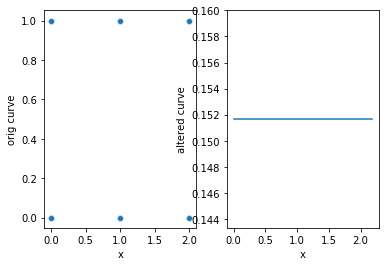

In [46]:
R, C = 1, 2

plt.subplot(R, C, 1)
# plt.plot(feat_vals, y, '.', alpha=0.5)
print(y.shape)
sns.scatterplot(feat_vals.flatten(), y, alpha=0.5, x_jitter=0.5, y_jitter=10)
plt.xlabel('x')
plt.ylabel('orig curve')

plt.subplot(R, C, 2)
plt.plot(x_axis, scores_on_spaced_line)
plt.xlabel('x')
plt.ylabel('altered curve')